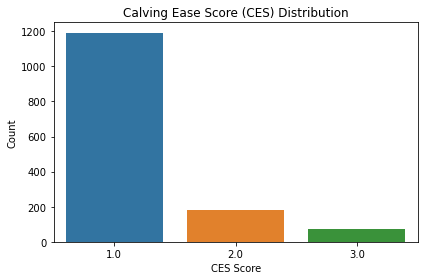

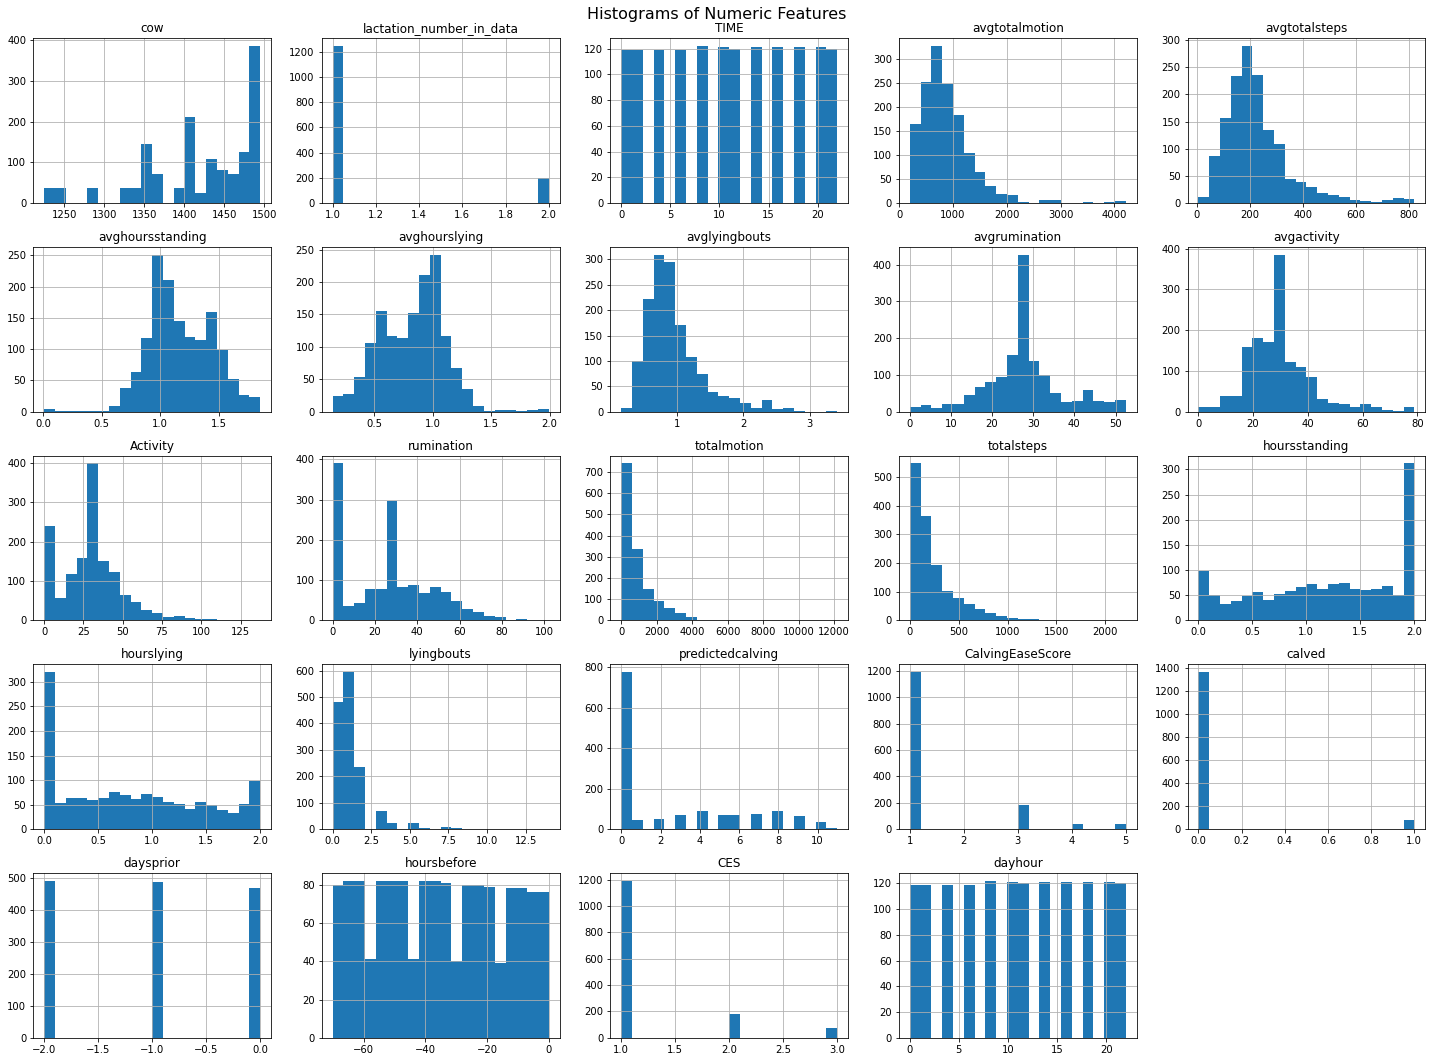

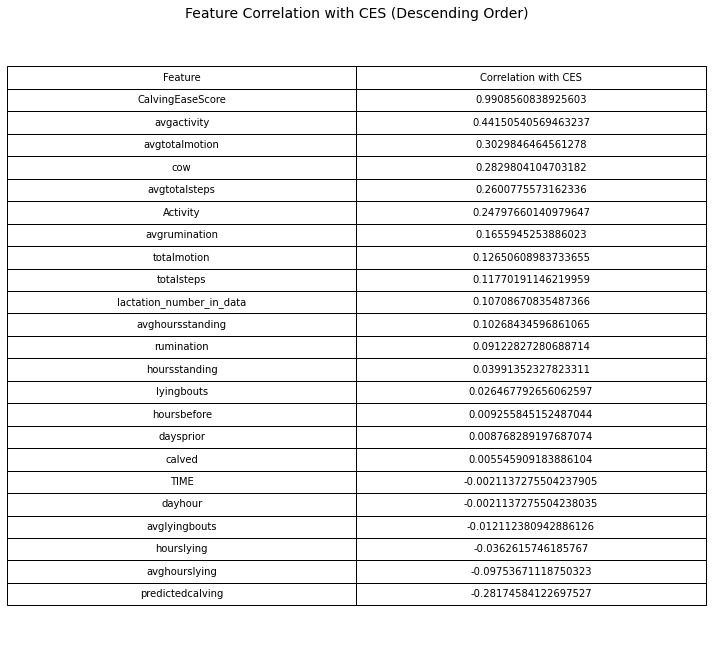

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For inline plotting in Jupyter (ignore if using .py file in VSCode terminal)
# %matplotlib inline

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# ------------------------------
# Load dataset
# ------------------------------
df = pd.read_csv('cowmonitoringsystem.csv')

# ------------------------------
# Step 0: Drop Completely Empty Rows
# ------------------------------
df = df.dropna(how='all')

# ------------------------------
# Step 1: Handle Missing Values
# ------------------------------

# Drop columns with only one unique value (e.g., constant features like breed = 'H')
df = df.drop(columns=[col for col in df.columns if df[col].nunique() == 1])

# Drop date columns
df = df.drop(columns=['date', 'calvdate'])

# ------------------------------
# Step 2: Encode Categorical Columns
# ------------------------------
categorical_cols = df.select_dtypes(include='object').columns

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert all to string in case of mixed types
    label_encoders[col] = le  # Save encoders in case needed later

# ------------------------------
# Step 3: Impute Missing Numeric Values
# ------------------------------
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())


# ------------------------------
# Step 2: Visual EDA
# ------------------------------

# 2a. CES class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='CES', data=df)
plt.title('Calving Ease Score (CES) Distribution')
plt.xlabel('CES Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2b. Histograms for numeric features
df[numeric_cols].hist(figsize=(20, 15), bins=20)
plt.suptitle('Histograms of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

# ------------------------------
# Step 3: Correlation with CES as Table
# ------------------------------
correlation_matrix = df[numeric_cols].corr()
correlation_with_target = correlation_matrix['CES'].drop('CES').sort_values(ascending=False)

# Convert to DataFrame for table display
correlation_df = pd.DataFrame({
    'Feature': correlation_with_target.index,
    'Correlation with CES': correlation_with_target.values
})

# Plot as table using matplotlib
fig, ax = plt.subplots(figsize=(10, len(correlation_df) * 0.4))
ax.axis('off')
table = ax.table(
    cellText=correlation_df.values,
    colLabels=correlation_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.title('Feature Correlation with CES (Descending Order)', fontsize=14)
plt.tight_layout()
plt.show()


Top 20 features by Mutual Information:
['cow', 'avgtotalmotion', 'avgtotalsteps', 'avghoursstanding', 'avghourslying', 'avglyingbouts', 'avgrumination', 'avgactivity', 'predictedcalving', 'CalvingEaseScore']

Top 20 features by RFE:
['cow', 'lactation_number_in_data', 'avgtotalmotion', 'avgtotalsteps', 'avghoursstanding', 'avghourslying', 'avglyingbouts', 'avgrumination', 'avgactivity', 'Activity', 'rumination', 'totalmotion', 'totalsteps', 'hoursstanding', 'hourslying', 'predictedcalving', 'CalvingEaseScore', 'parity', 'daysprior', 'hoursbefore']


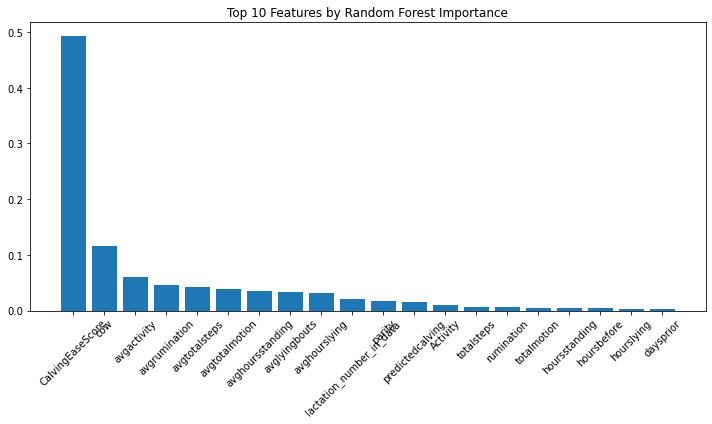


Top 10 features by Random Forest importance:
CalvingEaseScore: 0.4926
cow: 0.1169
avgactivity: 0.0596
avgrumination: 0.0468
avgtotalsteps: 0.0433
avgtotalmotion: 0.0387
avghoursstanding: 0.0355
avglyingbouts: 0.0327
avghourslying: 0.0325
lactation_number_in_data: 0.0210
parity: 0.0170
predictedcalving: 0.0163
Activity: 0.0099
totalsteps: 0.0059
rumination: 0.0058
totalmotion: 0.0050
hoursstanding: 0.0047
hoursbefore: 0.0043
hourslying: 0.0034
daysprior: 0.0028


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
import numpy as np

# ------------------------------
# Step 4a: Feature Engineering
# ------------------------------

# Interaction features
if 'lying_time' in df.columns and 'steps' in df.columns:
    df['lying_steps_interaction'] = df['lying_time'] * df['steps']

if 'eating_time' in df.columns and 'standing_time' in df.columns:
    df['eat_stand_ratio'] = df['eating_time'] / (df['standing_time'] + 1e-5)

if 'rumination_time' in df.columns and 'walking_speed' in df.columns:
    df['rum_walk_ratio'] = df['rumination_time'] / (df['walking_speed'] + 1e-5)

# Refresh numeric columns after new features
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# ------------------------------
# Step 4b: Prepare X and y
# ------------------------------
X = df.drop(columns=['CES'])
y = df['CES']

# ------------------------------
# Step 4c: SelectKBest with Mutual Information
# ------------------------------
selector_mi = SelectKBest(score_func=mutual_info_classif, k=10)
selector_mi.fit(X, y)
selected_features_mi = X.columns[selector_mi.get_support()]

print("Top 20 features by Mutual Information:")
print(selected_features_mi.tolist())

# ------------------------------
# Step 4d: Recursive Feature Elimination (RFE)
# ------------------------------
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_selector = RFE(estimator=rfc, n_features_to_select=20)
rfe_selector.fit(X, y)
selected_features_rfe = X.columns[rfe_selector.get_support()]

print("\nTop 20 features by RFE:")
print(selected_features_rfe.tolist())

# ------------------------------
# Step 4e: Random Forest Feature Importance Plot
# ------------------------------
rfc.fit(X, y)
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Features by Random Forest Importance")
plt.bar(range(20), importances[indices[:20]], align="center")
plt.xticks(range(20), X.columns[indices[:20]], rotation=45)
plt.tight_layout()
plt.show()

print("\nTop 10 features by Random Forest importance:")
for i in range(20):
    print(f"{X.columns[indices[i]]}: {importances[indices[i]]:.4f}")



CES class distribution:
 1.0    1191
2.0     180
3.0      72
Name: CES, dtype: int64


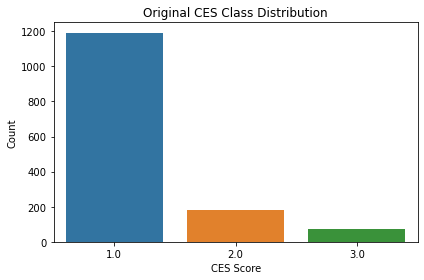

In [7]:
# Check distribution of CES
ces_counts = df['CES'].value_counts().sort_index()
print("CES class distribution:\n", ces_counts)

# Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='CES', data=df)
plt.title('Original CES Class Distribution')
plt.xlabel('CES Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [10]:
# ------------------------------
# Step 5: Model Selection with Cross-Validation
# ------------------------------
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Step 5a: Balance Classes using SMOTE
# ------------------------------
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X, y)

# Visualize class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_balanced)
plt.title('CES Distribution After SMOTE')
plt.xlabel('CES Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# ------------------------------
# Step 5b: Define Models
# ------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# ------------------------------
# Step 5c: Evaluate Using Stratified K-Fold
# ------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"--- {name} ---")
    
    # Accuracy
    acc_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=skf, scoring='accuracy')
    print(f"Accuracy Scores: {acc_scores}")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    
    # F1 Macro
    f1_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=skf, scoring='f1_macro')
    print(f"F1 Macro Scores: {f1_scores}")
    print(f"Mean F1 Macro: {np.mean(f1_scores):.4f}")
    print()


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    cohen_kappa_score
)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/kaggle/input/full-cow-data-set/cowmonitoringsystem.csv") #change accordingly

# Drop empty rows
df = df.dropna(how='all')

# Drop constant columns and date columns
df = df.drop(columns=[col for col in df.columns if df[col].nunique() == 1])
df = df.drop(columns=['date', 'calvdate'], errors='ignore')

# Encode categorical variables
categorical_cols = df.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Impute missing numeric values with mean
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# CES distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='CES', data=df)
plt.title('Calving Ease Score (CES) Distribution')
plt.xlabel('CES Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Histograms
df[numeric_cols].hist(figsize=(20, 15), bins=20)
plt.suptitle('Histograms of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

# Correlation with CES
correlation_matrix = df[numeric_cols].corr()
correlation_with_target = correlation_matrix['CES'].drop('CES').sort_values(ascending=False)

correlation_df = pd.DataFrame({
    'Feature': correlation_with_target.index,
    'Correlation with CES': correlation_with_target.values
})

fig, ax = plt.subplots(figsize=(10, len(correlation_df) * 0.4))
ax.axis('off')
table = ax.table(
    cellText=correlation_df.values,
    colLabels=correlation_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.title('Feature Correlation with CES (Descending Order)', fontsize=14)
plt.tight_layout()
plt.show()

# CES distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='CES', data=df)
plt.title('Calving Ease Score (CES) Distribution')
plt.xlabel('CES Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Histograms
df[numeric_cols].hist(figsize=(20, 15), bins=20)
plt.suptitle('Histograms of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

# Correlation with CES
correlation_matrix = df[numeric_cols].corr()
correlation_with_target = correlation_matrix['CES'].drop('CES').sort_values(ascending=False)

correlation_df = pd.DataFrame({
    'Feature': correlation_with_target.index,
    'Correlation with CES': correlation_with_target.values
})

fig, ax = plt.subplots(figsize=(10, len(correlation_df) * 0.4))
ax.axis('off')
table = ax.table(
    cellText=correlation_df.values,
    colLabels=correlation_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.title('Feature Correlation with CES (Descending Order)', fontsize=14)
plt.tight_layout()
plt.show()

# Interaction features
if 'lying_time' in df.columns and 'steps' in df.columns:
    df['lying_steps_interaction'] = df['lying_time'] * df['steps']

if 'eating_time' in df.columns and 'standing_time' in df.columns:
    df['eat_stand_ratio'] = df['eating_time'] / (df['standing_time'] + 1e-5)

if 'rumination_time' in df.columns and 'walking_speed' in df.columns:
    df['rum_walk_ratio'] = df['rumination_time'] / (df['walking_speed'] + 1e-5)

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

target_col = 'CES'
X = df.drop(columns=[target_col])
y = df[target_col] - df[target_col].min()  # Fix: shift CES to start at 0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print("Class distribution in train:", y_train.value_counts().to_dict())
print("Class distribution in test: ", y_test.value_counts().to_dict())

# Logistic Regression pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=2000, solver='saga'))
])

models = {
    'Logistic Regression': lr_pipeline,
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Evaluate each model
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'gamma': [0, 0.2],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("\nBest XGBoost Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Cohen's Kappa Score:", cohen_kappa_score(y_test, y_pred))

